# Scenario Analysis, Delta-Vega-Gamma Approximations and Efficient Frontiers 

Scenario Analysis and Modern Portfolio Theory with Python by Jaume Clave  
May 17, 2020

This paper begins with a scenario analysis involving three large market index securities. Scenario analysis is important a priori information to a risk or portfolio manager and helps to control the effect of price changes to a portfolio, especially those of potential market crashes. The project continues with an investigation of the mean-variance analysis of Markowitz (1952) when there is no risk-free asset and then move on to the case where there is a risk-free asset available. We also discuss the difficulties of implementing mean-variance analysis in practice and outline some approaches for resolving these difficulties. Because optimal asset allocations are typically very sensitive to estimates of expected returns and covariances, these approaches typically involve superior or more robust parameter estimation methods.

This project introduces important terminology used in the financial industry relevant for scenario analysis, profit and loss approximations, portfolio simulations and efficient frontiers. Each section contains code use to transform raw data into tables and visualizations that help understand and interpret the theory. Mathematical expressions are derived where appropriate.

[Scenario Analysis I](#Scenario-Analysis-I)   
i. [Scenario Analysis](#Scenario-Analysis)  
i. [Pivot Table](#Pivot-Table)   
ii. [S&P 500 Pivot Table](#S&P-500-Pivot-Table)

[Delta-Vega-Gamma Approximations and Scenario Analysis II](#Delta-Vega-Gamma-Approximations-and-Scenario-Analysis-II)  
i. [Market Index](#Market-Index)  
ii. [S&P 500 Index](#S&P-500-Index)  
iii. [SX5E Index](#SX5E-Index)   
iv. [NKY Index](#NKY-Index)  
v. [Total Delta](#Total-Delta)  
vi. [Total Gamma](#Total-Gamma)  
vii. [Total Vega 1%](#Total-Vega-1%)  
viii. [Comparing P&L to Pivot-Table P&L D-G-V Approximation](#Comparing-P&L-to-Pivot-Table-P&L-D-G-V-Approximation)

[Simulation and Construction of Actual, Estimated and True Efficient Frontiers](#Simulation-and-Construction-of-Actual,-Estimated-and-True-Efficient-Frontiers)  
i. [Generating 5 Years of Monthly Returns with multivariate_normal](#Generating-5-Years-of-Monthly-Returns-with-multivariate_normal)  
ii. [Covariance Matrix](#Covariance-Matrix)  
iii. [Expected (Realized) Efficient Frontier](#Expected-(Realized)-Efficient-Frontier)  
iv. [Modern Portfolio Theory](#Modern-Portfolio-Theory)  
v. [Diversification](#Diversification)  
vi. [Sharpe Ratio](#Sharpe-Ratio)   
vii. [Efficient Frontier with no Risk-Free Asset](#Efficient-Frontier-with-no-Risk-Free-Asset)  
viii. [Actual Frontier](#Actual-Frontier)  
ix. [True Frontier](#True-Frontier)  
x. [Actual, Estimated, and True Frontier](#Actual,-Estimated,-and-True-Frontier)  
xi. [Problems with Traditional Mean-Variance Analysis](#Problems-with-Traditional-Mean-Variance-Analysis)  

[Conclusion](#Conclusion)  
[Further Reading](#Further-Reading)


In [1]:
## Import modules
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

## Scenario Analysis I
This section introduces the concept of scenario analysis and ultimately constructs a pivot-table showing the total P&L in each scenario for all securities with the S&P 500 as the underlying security. The data is initially explored and correlations are visualised by correlation heatmaps. Data is then aggregated and presented using the pandas pivot_table method.


In [2]:
## Import data
data = pd.read_csv('StressData.csv')

Each row of the file contains data on a particular security (option or futures contract) that arises from a particular scenario. The scenarios that were considered are all combinations of the underlying moving by {±20%, ±10%, ±5%, ±2%, ±1%, 0%} and implied volatilities moving by {±10, ±5, ±2, ±1, 0} percentage points.

In [3]:
stress_data = data.copy()
print(f'The dataset has {stress_data.shape[0]} rows and {stress_data.shape[1]} columns')
stress_data.head()

The dataset has 8217 rows and 30 columns


,Underlying Stress,Volatility Stress,Underlying,Underlying Price,Div. Yield,Security Type,Currency,Position,Strike,CallPut,...,Volga,1 Day Theta,Rho (1%),Total $Delta,Total $Gamma,Total Vega 1%,Total Volga,Total 1 Day Theta,Total Rho,PnL
0,-20,-10,SPX Index,"1,100",2.00%,Future,USD,25,NaN,NaN,...,0,0,13,"27,208",0,0,0,1,323,"-5,442"
1,-20,-10,SPX Index,"1,100",2.00%,Option,USD,200,935,Put,...,36,0,-5,"-62,125","75,972",800,"7,261",-42,"-1,032","8,461"
2,-20,-10,SPX Index,"1,100",2.00%,Option,USD,-50,"1,001",Put,...,-4,0,-6,"18,328","-23,586",-215,199,10,295,"-2,904"
3,-20,-10,SPX Index,"1,100",2.00%,Option,USD,25,"1,100",Put,...,-43,0,-7,"-11,859","14,966",115,"-1,081",-5,-187,"2,255"
4,-20,-10,SPX Index,"1,100",2.00%,Option,USD,-25,"1,034",Put,...,-26,0,-6,"9,990","-12,962",-111,655,5,159,"-1,697"


In [4]:
## Formatting column types function
def format_df(dataframe):
    dataframe.replace(',', '', regex = True, inplace = True)

    for col in dataframe.columns:
        try:
            dataframe[col] = dataframe[col].astype(int)
        except:
            print(f'{col} was not able to become an int column')

    dataframe['Maturity'] = pd.to_datetime(dataframe['Maturity'])

In [5]:
## Format stress_data
format_df(stress_data)

Underlying was not able to become an int column
Div. Yield was not able to become an int column
Security Type was not able to become an int column
Currency was not able to become an int column
Strike was not able to become an int column
CallPut was not able to become an int column
Maturity was not able to become an int column
Imp. Vol was not able to become an int column
Risk-Free Rate was not able to become an int column
CounterParty was not able to become an int column
Margin was not able to become an int column


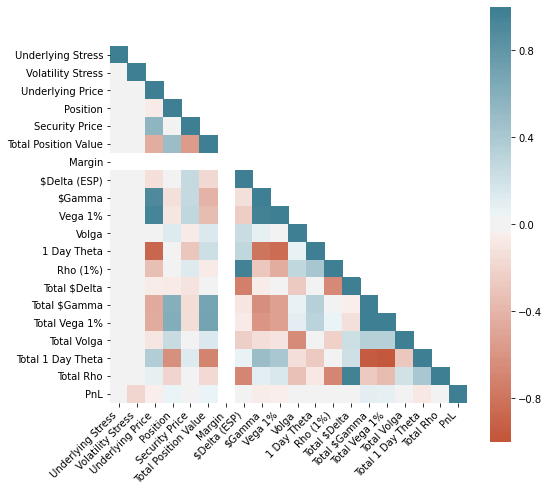

In [6]:
## Correlation matrix
corr = stress_data.corr()

## Create triangle df
np.tril(np.ones(corr.shape)).astype(np.bool)[:, :]
df_lt = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))

## Plot
plt.figure(figsize = (8, 8))
ax = sns.heatmap(df_lt, vmin = -1, vmax = 1, center = 0, cmap = sns.diverging_palette(20, 220, n = 200), square = True)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show()

Function used to imporve the correlation matrix by building a robust parametrized function that makes heatmaps with sized markers. 

In [7]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) 
    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) 
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 
        'y_order', 'xlabel', 'ylabel'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    ax.set_xlabel(kwargs.get('xlabel', ''))
    ax.set_ylabel(kwargs.get('ylabel', ''))

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right
        plt.gca().spines['right'].set_color('none')
        plt.gca().spines['top'].set_color('none')
        plt.gca().spines['bottom'].set_color('none')
        plt.gca().spines['left'].set_color('none')
        
def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index').replace(np.nan, 0)
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

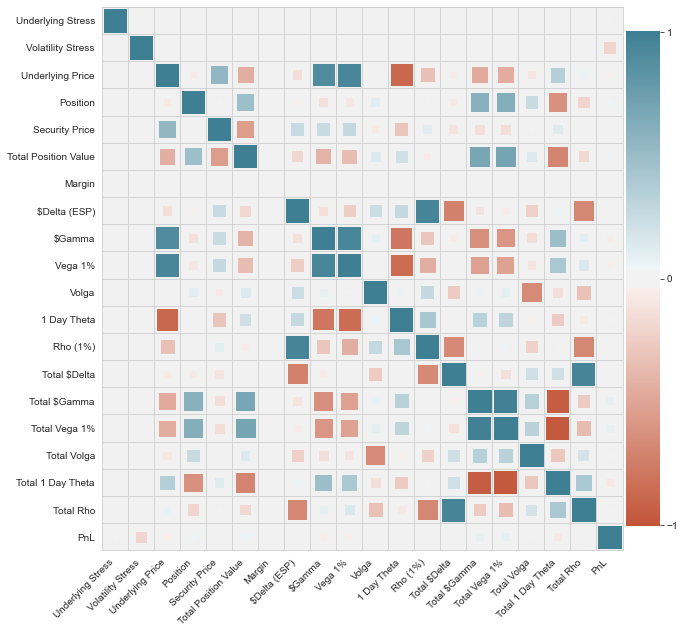

In [8]:
## Plotting
#df_lt.fillna(0, inplace = True)
sns.set_style("whitegrid")
plt.figure(figsize  =(10, 10))
corrplot(corr.T)

### Scenario Analysis
The scenario approach to risk management defines a number of scenarios where in each scenario various risk factors, e.g. the price of the underlying security and implied volatility, are assumed to have moved by some fixed amounts. For example, a scenario might assume that all stock prices have fallen by 10% and all implied volatilities have increased by 5 percentage points. Another scenario might assume the same movements but with an additional steepening of the volatility surface. The risk of a portfolio could then be determined by computing the P&L in each scenario and then considering the results, taking action (to reduce risk) where appropriate. This risk factors and scenario variations can be displayed through a pivot table.

These assessments can be used to examine the amount of risk present within a given investment as related to a variety of potential events, ranging from highly probable to highly improbable. Depending on the result of the analysis, an investor can determine if the level of risk present falls within his comfort zone.

One type of scenario analysis that looks specifically at worst-case scenarios is stress testing. These are computer simulations techniques used to test the resilience of institutions and investment portfolios against possible future financial situations. Such testing is customarily used by the financial industry to help gauge investment risk and the adequacy of assets, as well as to help evaluate internal processes and controls. In recent years, regulators have also required financial institutions to carry out stress tests to ensure their capital holdings and other assets are adequate.

        - Scenario analysis is the process of estimating the expected value of a portfolio after a given change in 
        the values of key factors take place.
        - Both likely scenarios and unlikely worst-case events can be tested in this fashion—often relying on 
        computer simulations.
        - Scenario analysis can apply to investment strategy as well as corporate finance.

There are many different ways to approach scenario analysis. A common method is to determine the standard deviation of daily or monthly security returns and then compute what value is expected for the portfolio if each security generates returns that are two or three standard deviations above and below the average return. This way, an analyst can have a reasonable amount of certainty regarding the change in the value of a portfolio during a given time period, by simulating these extremes.

### Pivot Table
A pivot table is a table of statistics that summarizes the data of a more extensive table. Pivot tables are a technique in data processing. They arrange and rearrange (or "pivot") statistics in order to draw attention to useful information. A pivot table can help quickly summarize the data and highlight the desired information. A pivot table usually consists of row, column and data (or fact) fields. In this case, the column is Volatility Stress, the row is Underlying and Underlying Stress and the data seen is (sum of) PnL. These fields allow several kinds of aggregations, including: sum, average, standard deviation, count, etc. In this case, the total value of PnL is displayed here using a sum aggregation.

The below code shows the pivot table for all three different underlying securities:

In [9]:
## All security pivot table
table = pd.pivot_table(
    stress_data, index = ['Underlying', 'Underlying Stress'], columns = ['Volatility Stress'], values = ['PnL'], 
    aggfunc = np.sum)
table

PnL                                      \
Volatility Stress                -10    -5     -2     -1      0       1    
Underlying Underlying Stress                                               
NKY Index  -20                 55189  14429 -12516 -21817 -31261  -40830   
           -10                115610  59262  24358  12592    780  -11076   
           -5                 129655  67518  29705  17044   4362   -8335   
           -2                 132755  67986  28835  15757   2676  -10412   
           -1                 132909  67410  27883  14688   1491  -11708   
            0                 132623  66475  26602  13303      0  -13303   
            1                 131906  65181  25009  11606  -1792  -15187   
            2                 130757  63541  23092   9605  -3881  -17361   
            5                 124801  56541  15476   1792 -11899  -25579   
            10                106836  38274  -3153 -16988 -30831  -44679   
            20                 44121 -20473 -60530 -74035 -87602 -101228   
SPX Index  -20                 -1276  -5350  -7886  -8740  -9595  -10454   
           -10                  6994   1614  -1511  -2535  -3555   -4569   
           -5                   9570   3904    640   -429  -1493   -2545   
           -2                  10652   4923   1626    544   -531   -1596   
           -1                  10942   5210   1907    820   -252   -1324   
            0                  11193   5471   2164   1079      0   -1071   
            1                  11412   5702   2397   1312    233    -838   
            2                  11597   5912   2611   1527    447    -626   
            5                  11971   6387   3122   2047    972     -99   
            10                 12030   6748   3585   2536   1483     433   
            20                 10502   6081   3259   2299   1332     360   
SX5E Index -20                  7232  -3487 -10771 -13305 -15884  -18509   
           -10                 29405  13522   3662    340  -2995   -6346   
           -5                  35540  17726   6927   3319   -293   -3908   
           -2                  37553  18872   7645   3904    164   -3573   
           -1                  37948  19033   7684   3906    128   -3645   
            0                  38205  19078   7622   3810      0   -3808   
            1                  38329  19017   7465   3619   -222   -4056   
            2                  38320  18848   7205   3337   -529   -4396   
            5                  37494  17696   5868   1933  -1997   -5923   
            10                 33611  13756   1826  -2153  -6131  -10101   
            20                 17547   -923 -12380 -16245 -20123  -24017   

                                                      
Volatility Stress                 2       5       10  
Underlying Underlying Stress                          
NKY Index  -20                -50514  -80178 -131198  
           -10                -22978  -58872 -119118  
           -5                 -21039  -59215 -122881  
           -2                 -23502  -62761 -128086  
           -1                 -24908  -64490 -130296  
            0                 -26603  -66472 -132738  
            1                 -28577  -68716 -135405  
            2                 -30840  -71220 -138300  
            5                 -39257  -80239 -148309  
            10                -58526 -100078 -169210  
            20               -114894 -156150 -225434  
SPX Index  -20                -11315  -13892  -18182  
           -10                 -5576   -8563  -13440  
           -5                  -3590   -6690  -11737  
           -2                  -2654   -5798  -10914  
           -1                  -2387   -5532  -10670  
            0                  -2135   -5291  -10443  
            1                  -1905   -5065  -10226  
            2                  -1688   -4853  -10028  
            5                  -1159   -4324   -9513  
            10                 

### The S&P 500 Index
The pivot table below shows the P&L under various scenarios of an options portfolio with the S&P 500 as the underlying security. The 
vertical axis represents percentage shifts in the price of the underlying security, i.e. the S&P 500, whereas the horizontal axis represents absolute changes in the implied volatility of each option in the portfolio. For example, we see that if the S&P 500 were to fall by 20% and implied volatilities were to all rise by 5 percentage points, then the portfolio would lose 13.892 million dollars (assuming that the numbers in pivot table are expressed in units of 1,000 dollars)

In [10]:
## S&P 500 pivot table
SP5_table = pd.pivot_table(
    stress_data[stress_data['Underlying'] == 'SPX Index'], index = ['Underlying', 'Underlying Stress'], 
    columns = ['Volatility Stress'], values = ['PnL'], 
    aggfunc = np.sum)
SP5_table

PnL                                        \
Volatility Stress               -10   -5    -2    -1     0      1      2    
Underlying Underlying Stress                                                
SPX Index  -20                -1276 -5350 -7886 -8740 -9595 -10454 -11315   
           -10                 6994  1614 -1511 -2535 -3555  -4569  -5576   
           -5                  9570  3904   640  -429 -1493  -2545  -3590   
           -2                 10652  4923  1626   544  -531  -1596  -2654   
           -1                 10942  5210  1907   820  -252  -1324  -2387   
            0                 11193  5471  2164  1079     0  -1071  -2135   
            1                 11412  5702  2397  1312   233   -838  -1905   
            2                 11597  5912  2611  1527   447   -626  -1688   
            5                 11971  6387  3122  2047   972    -99  -1159   
            10                12030  6748  3585  2536  1483    433   -614   
            20                10502  6081  3259  2299  1332    360   -619   

                                            
Volatility Stress                5      10  
Underlying Underlying Stress                
SPX Index  -20               -13892 -18182  
           -10                -8563 -13440  
           -5                 -6690 -11737  
           -2                 -5798 -10914  
           -1                 -5532 -10670  
            0                 -5291 -10443  
            1                 -5065 -10226  
            2                 -4853 -10028  
            5                 -4324  -9513  
            10                -3741  -8912  
            20                -3593  -8597

## Delta-Vega-Gamma Approximations and Scenario Analysis II
This section contains a piece of code to display the sum of the ‘Total \\$Delta’ (column V) grouped by the underlying security. Since there are just three underlying securities, the codes outputs three ‘Total \\$Delta’s: one for each underlying. Each of these “Total \\$Delta”s are denominated in different currencies and it wouldn’t make sense to add them together without first converting them all to a common currency. The currency used will be USD. This process will be repeated for Total \\$Gamma and Total Vega 1%.

In [11]:
## Import data
data = pd.read_csv('OptionsData.csv')

In [12]:
## Dataframe info
options_data = data.copy()
print(f'The dataset has {options_data.shape[0]} rows and {options_data.shape[1]} columns')
options_data.head()

The dataset has 83 rows and 27 columns


,Underlying,Underlying Price,Div. Yield,Security Type,Currency,Position,Strike,CallPut,Maturity,Imp. Vol,...,Vega 1%,Volga,1 Day Theta,Rho (1%),Total $Delta,Total $Gamma,Total Vega 1%,Total Volga,Total 1 Day Theta,Total Rho
0,SPX Index,1100,2.00%,Future,USD,25,NaN,NaN,19-Mar-10,NaN,...,0.0,0.0,0.0,12.91,27208,0,0,0,1,323
1,SPX Index,1100,2.00%,Option,USD,200,935.0,Put,19-Mar-10,44.40%,...,4.0,36.3,-0.2,-5.16,-62125,75972,800,7261,-42,-1032
2,SPX Index,1100,2.00%,Option,USD,-50,1001.0,Put,19-Mar-10,38.40%,...,4.3,-4.0,-0.2,-5.90,18328,-23586,-215,199,10,295
3,SPX Index,1100,2.00%,Option,USD,25,1100.0,Put,19-Mar-10,32.50%,...,4.6,-43.2,-0.2,-7.50,-11859,14966,115,-1081,-5,-187
4,SPX Index,1100,2.00%,Option,USD,-25,1034.0,Put,19-Mar-10,36.00%,...,4.4,-26.2,-0.2,-6.37,9990,-12962,-111,655,5,159


In [13]:
## Format options_data
format_df(options_data)

Underlying was not able to become an int column
Div. Yield was not able to become an int column
Security Type was not able to become an int column
Currency was not able to become an int column
Strike was not able to become an int column
CallPut was not able to become an int column
Maturity was not able to become an int column
Imp. Vol was not able to become an int column
Risk-Free Rate was not able to become an int column
CounterParty was not able to become an int column
Margin was not able to become an int column


In [14]:
print(f"The three underlying securities are the {options_data['Underlying'].unique()[0]}," 
      f"the {options_data['Underlying'].unique()[1]} and the {options_data['Underlying'].unique()[2]}")

The three underlying securities are the SPX Index,the SX5E Index and the NKY Index


### Market Index
A market index is a hypothetical portfolio of investment holdings which represents a segment of the financial market. The calculation of the index value comes from the prices of the underlying holdings. Some indices have values based on market-cap weighting, revenue weighting, float-weighting and fundamental-weighting. Weighting is a method of adjusting the individual impact of items in an index.

An investor can't invest directly in an market index, so these indicators as portfolios are used broadly as benchmarks. Each index has its own methodology which is calculated and maintained by the index provider. Indexes are deeply entrenched in the investment management business with funds using them as benchmarks for performance comparisons and managers using them as the basis for creating investable index funds.

        - Market indexes provide a broad representative portfolio of investment holdings.
        - Methodologies for constructing individual indexes vary but nearly all calculations are based on 
        weighted average mathematics.
        - Indexes are used as benchmarks to gauge the movement and performance of market segments.
        - Investors use indexes as a basis for portfolio or passive index investing.

As a hypothetical portfolio of holdings, indexes act as a benchmark comparisons for a variety of purposes across the financial markets. The Dow Jones Industrial Average, S&P 500 and Nasdaq Composite are three popular U.S. indices. These three indexes include the 30 largest stocks in the U.S. by market cap, the 500 largest stocks and all of the stocks on the Nasdaq exchange, respectively. Since they include some of the most significant U.S. stocks, these benchmarks can be a good representation of the overall U.S. stock market. This project observers the SPX Index, the SX5E Index and the NKY Index.


### S&P 500 Index
The S&P 500 measures the stock performance of 500 large companies listed on stock exchanges in the United States. The average annual total return of the index, including dividends, since inception in 1926 has been 9.8%; with several years where the index declined over 30%. The index has posted annual increases 70% of the time. Its market cap was US$28.1 trillion as of early 2020.

The components of the S&P 500 are selected by a committee. When considering the eligibility of a new addition, the committee assesses the company's merit using eight primary criteria: market capitalization, liquidity, domicile, public float, sector classification, financial viability, and length of time publicly traded and stock exchanged. 

 order to be added to the index, a company must satisfy the following liquidity-based size requirements:

    1. Market capitalization must be greater than or equal to US$8.2 billion
    2. Annual dollar value traded to float-adjusted market capitalization is greater than 1.0
    3. Minimum monthly trading volume of 250,000 shares in each of the six months leading up to the evaluation date

The committee selects the companies in the S&P 500 so they are representative of the industries in the Economy of the United States.


### SX5E Index
The EURO STOXX 50 is a stock index of Eurozone stocks designed by STOXX, an index provider owned by the  Deutsche Börse Group. The goal, according to STOXX, is "to provide a blue-chip representation of Supersector leaders in the Eurozone." It is made up of fifty of the largest and most liquid stocks. Its market cap as of mid 2020 is just under EUR2 trillion.

The index covers 50 stocks from 8 Eurozone countries: Belgium, Finland, France, Germany, Ireland, Italy, Luxembourg, the Netherlands and Spain. The EURO STOXX 50 Index is licensed to financial institutions to serve as an underlying for a wide range of investment products such as exchange-traded funds (ETFs), futures, options and structured products worldwide.


### NKY Index
The Nikkei 225 is a stock market index of the Tokyo Stock Exchange (TSE). It has been calculated daily by the Nihon Keizai Shinbun (The Nikkei) newspaper since 1950. t is a price-weighted index, operating in the Japanese Yen (JP¥), and its components are reviewed once a year. The Nikkei measures the performance of 225 large, publicly owned companies in Japan from a wide array of industry sectors. Its market cap as of early 2019 was US$5.67 trillion.

It is a price-weighted index, operating in the Japanese Yen (JP¥), and its components are reviewed once a year. There is concern that the rise since 2013 is artificial and due to purchases by the Bank of Japan ("BOJ"). From a start in 2013, by end 2017, The BOJ owned circa 75% of all Japanese Exchange Traded Funds ("ETFs"), and are a top 10 shareholder of 90% of the Nikkei 225 constituents.


### Total \\$Delta
This section converts different currencies into USD and proceeds to sum the Total \\$Delta for each underlying security

#### Delta $(\Delta)$
Delta represents the rate of change between the option's price and a \\$1 change in the underlying asset's price. In other words, the price sensitivity of the option relative to the underlying. If an investor is long a call option with a delta of 0.50. Therefore, if the underlying stock increases by \\$1, the option's price would theoretically increase by 50 cents. 

The (absolute value of) Delta is close to, but not identical with, the percent moneyness of an option, i.e., the implied probability that the option will expire in-the-money (if the market moves under Brownian motion in the risk-neutral measure).

For option traders, delta also represents the hedge ratio for creating delta-neutral position. If an investor purchases a standard American call option with a 0.40 delta, the investor will need to sell 40 shares of stock to be fully hedged. Net delta for a portfolio of options can also be used to obtain the portfolio's hedge ration.

In [15]:
## Function to return underlying column sum
def underlying_sum(column):
    return options_data.groupby('Underlying')[column].sum()

This returns the total deltas for each underlying security but in this sumation each underlying security is expressed in a different currency. 

        NKY Index (Japan) is expressed in Japanese Yen
        SPX Index (U.S) is expressed in US Dollars
        SX5E Index (Europe) is expressed in Euros
                

In [16]:
underlying_sum('Total $Delta')

Underlying
NKY Index    -164156
SPX Index      24442
SX5E Index    -17486
Name: Total $Delta, dtype: int32

First step in this process is to ensure that all monetary figures are expressed in the same currency.

In [17]:
from forex_python.converter import CurrencyRates
c = CurrencyRates()

def currency_converter(currency, value_column):
    df = options_data[options_data['Currency'] == currency]
    df_l = df[value_column].tolist()
    df_l = [round(c.convert(currency, 'USD', x)) for x in df_l]
    return df_l

In [18]:
usd_l = currency_converter('USD', 'Total $Delta')
eur_l = currency_converter('EUR', 'Total $Delta')
jpy_l = currency_converter('JPY', 'Total $Delta')

In [19]:
usd_all = usd_l + eur_l + jpy_l

In [20]:
options_data['USD Total $Delta'] = usd_all

The Delta values are now all in the same currency, US Dollars, the grouping and aggregation can now continue.

In [21]:
underlying_sum('USD Total $Delta')

Underlying
NKY Index     -1535
SPX Index     24442
SX5E Index   -18881
Name: USD Total $Delta, dtype: int64

Because the process is to be repeated various times for different columns, a function is coded to faciliate the repetition of the process.

In [22]:
def underlying_security_sum(value_column, new_df_column):

    usd_l = currency_converter('USD', value_column)
    eur_l = currency_converter('EUR', value_column)
    jpy_l = currency_converter('JPY', value_column)
    usd_all = usd_l + eur_l + jpy_l
    options_data[new_df_column] = usd_all

    return underlying_sum(new_df_column)

### Total Gamma
This section replicates the process above which converts different currencies into USD and proceeds to sum the Total \\$Gamma for each underlying security.

#### Gamma $(\Gamma)$
Gamma represents the rate of change between an option's delta and the underlying asset's price. This is called second-order (second-derivative) price sensitivity. Gamma indicates the amount the delta would change given a \\$1 move in the underlying security. If an investor is long one call option on hypothetical stock XYZ. The call option has a delta of 0.50 and a gamma of 0.10. Therefore, if stock XYZ increases or decreases by \\$1, the call option's delta would increase or decrease by 0.10.

Gamma is greatest approximately at-the-money (ATM) and diminishes the further out you go either in-the-money (ITM) or out-of-the-money (OTM). Gamma is important because it corrects for the convexity of value. 

Options traders may opt to not only hedge delta but also gamma in order to be delta-gamma neutral, meaning that as the underlying price moves, the delta will remain close to zero.

In [23]:
underlying_security_sum('Total $Gamma', 'USD Total $Gamma')

Underlying
NKY Index     -14095
SPX Index    -103722
SX5E Index   -494707
Name: USD Total $Gamma, dtype: int64

### Total Vega 1%
This section replicates the process above which converts different currencies into USD and proceeds to sum the Total Vega 1% for each underlying security.

#### Vega $(V)$
Vega represents the rate of change between an option's value and the underlying asset's implied volatility/ This is the option's sensitivity to volatility. Vega indicates the amount an option's price changes given a 1% change in implied volatility. An option with a Vega of 0.10 indicates the option's value is expected to change by 20 cents if the implied volatility changed by 1%

Vega can be an important Greek to monitor for an option trader, especially in volatile markets, since the value of some option strategies can be particularly sensitive to changes in volatility. 

Because increased volatility implies that the underlying instrument is more likely to experience extreme values, a rise in volatility will correspondingly increase the value of an option. Conversely, a decrease in volatility will negatively affect the value of the option. Vega is at its maximum for at-the-money options that have longer times until expiration.


In [24]:
underlying_security_sum('Total Vega 1%', 'USD Total Vega 1%')

Underlying
NKY Index     -126
SPX Index    -1074
SX5E Index   -4115
Name: USD Total Vega 1%, dtype: int64

### Comparing P&L to Pivot-Table P&L D-G-V Approximation
Using the dollar values of each variable we can approximate the P&L to changes in both the underlying’s price and volatility. The formula used for the approximations are:

$$PnL = \delta S(\frac{\Delta S}{S})+\frac{\Gamma S^2}{2} * (\frac{\Delta S}{S})^2 + vega \Delta \sigma$$

The Delta-Gamma-Vega Approximation is very accurate estimating the P&L for small changes. The higher the change, the worse is the approximation. The results are therefore consistent with what is expected given the pivot table found above, as the approximation in general only holds for small changes. 

## Simulation and Construction of Actual, Estimated and True Efficient Frontiers
The purpose of this section is to explore the effect of estimation error on the computation of efficient portfolios by comparing the “true”, “estimated”, and “actual” efficient frontiers. To that end, the expected return and covariance matrix imported from .csv are the “true” values for the expected returns and covariances for a set of eight assets. These are monthly expected returns and covariances. This section will introduce essential terminology tied into mean-variance optimization.

In [25]:
## Read the cov_matrix data
data = pd.read_csv('covariance_matrix.csv')
cov_mtx = data.copy()
cov_mtx.set_index('Asset Class', inplace = True)

In [26]:
## Covariance matrix
cov_mtx 

,Euro bonds,US bonds,Canada,France,Germany,Japan,UK,USA
Asset Class,,,,,,,,
Euro bonds,0.000243,0.000288,0.000283,0.000285,0.000272,0.000176,0.000272,0.000282
US bonds,0.000288,0.000404,0.000287,0.000311,0.000338,0.000198,0.000302,0.000311
Canada,0.000283,0.000287,0.003025,0.001585,0.001026,0.000968,0.001917,0.001679
France,0.000285,0.000311,0.001585,0.004942,0.002711,0.002079,0.002282,0.001330
Germany,0.000272,0.000338,0.001026,0.002711,0.003869,0.001533,0.001794,0.000909
Japan,0.000176,0.000198,0.000968,0.002079,0.001533,0.004956,0.001692,0.000666
UK,0.000272,0.000302,0.001917,0.002282,0.001794,0.001692,0.003612,0.001447
USA,0.000282,0.000311,0.001679,0.001330,0.000909,0.000666,0.001447,0.001849


In [27]:
## Numpy array
cov = cov_mtx.to_numpy()

In [28]:
## Read the expected returns data
data = pd.read_csv('expected_returns.csv')
exp_rtns = data.copy()
exp_rtns.set_index('Asset class', inplace = True)
exp_rtns.replace('%', '', regex = True, inplace = True)

In [29]:
## Change datatype
exp_rtns['Expected Return (%)'] = exp_rtns['Expected Return (%)'].astype(float)
exp_rtns['Standard Dev (%)'] = exp_rtns['Standard Dev (%)'].astype(float)

In [30]:
## Expected returns
exp_rtns

,Expected Return (%),Standard Dev (%)
Asset class,,
Euro bonds,0.27,1.56
US bonds,0.25,2.01
Canada,0.39,5.50
France,0.88,7.03
Germany,0.53,6.22
Japan,0.88,7.04
UK,0.79,6.01
USA,0.71,4.30


In [31]:
## Numpy array
mean = exp_rtns['Expected Return (%)'].to_numpy()

### Generating 5 Years of Monthly Returns with multivariate_normal
The numpy.random.multivariate_normal draws random samples from a multivariate normal distribution.

The multivariate normal, multinormal or Gaussian distribution is a generalization of the one-dimensional normal distribution to higher dimensions. Such a distribution is specified by its mean and covariance matrix. These parameters are analogous to the mean (average or “center”) and variance (standard deviation, or “width,” squared) of the one-dimensional normal distribution.

The mean is a coordinate in N-dimensional space, which represents the location where samples are most likely to be generated. This is analogous to the peak of the bell curve for the one-dimensional or univariate normal distribution.

Covariance indicates the level to which two variables vary together. From the multivariate normal distribution, we draw N-dimensional samples, $X = [x_1, x_2, ... x_N]$. The covariance matrix element $C_{ij}$ is the covariance of $x_i$ and $x_j$. The element $C_{ii}$ is the variance of $x_i$ (i.e. its “spread”).

In [32]:
## multivariate normal
monthly_returns = np.random.multivariate_normal(mean, cov_mtx, size = 60).T

In [33]:
## Sample mean
sample_mean = monthly_returns.mean()

### Covariance Matrix
A covariance matrix (or variance-covariance matrix) is a square matrix is a square matrix giving the covariance between each pair of elements of a given random vector. Intuitively, the covariance matrix generalises the notion of variance to multiple dimensions. 

Covariance is a measure of the joint variability of two random variables. If the greater values of one variable mainly correspond with the greater values of the other variable, and the same holds for the lesser values, the covariance is positive. In the opposite case, when the greater values of one variable mainly correspond to the lesser values of the other, the covariance is negative. The sign of the covariance therefore shows the tendency in the linear relationship between the variables. The magnitude of the covariance is not easy to interpret because it is **not normalized** and hence depends on the magnitudes of the variables. The normalized version of the covariance, the correlation coefficient, however, shows by its magnitude the strength of the linear relation.

A covariance matrix is a $nxn$ symmetric matrix where $n$ is the number of columns of the matrix you are starting with and shows how the vector variables **covariate**, meaning how they tend to move in relation to one another.


In [34]:
## Sample Covariance matrix
sample_cov_rtns = np.cov(monthly_returns)
sample_cov_rtns = pd.DataFrame(sample_cov_rtns)
sample_cov_rtns.columns = cov_mtx.columns
sample_cov_rtns

,Euro bonds,US bonds,Canada,France,Germany,Japan,UK,USA
0,0.000238,0.000300,0.000414,0.000219,0.000164,0.000174,0.000252,0.000317
1,0.000300,0.000424,0.000572,0.000364,0.000305,0.000123,0.000350,0.000335
2,0.000414,0.000572,0.004958,0.002446,0.001548,0.001736,0.002656,0.002349
3,0.000219,0.000364,0.002446,0.005005,0.002746,0.001435,0.002830,0.001425
4,0.000164,0.000305,0.001548,0.002746,0.003899,0.000297,0.002031,0.000678
5,0.000174,0.000123,0.001736,0.001435,0.000297,0.004026,0.001440,0.000709
6,0.000252,0.000350,0.002656,0.002830,0.002031,0.001440,0.003717,0.001571
7,0.000317,0.000335,0.002349,0.001425,0.000678,0.000709,0.001571,0.002221


On the main diagonal the variance of each vector and on all other coordinates the covariance is found since $Var(X) = cov(X, X)$

In the main diagonal no values can be negative since they represent the variance of a vector. On any other position,
the covariance can be obtained as a product of two standard deviations (that are always non negative) ($s(x)$ and $s(Y)$) and the Pearsons correlation coefficient $p$ that instead varies between $[-1, 1]$: this is what makes the coefficient that makes the values positive or negative. 

$$cov(X, Y) = p(X, y)s(X)s(Y)$$

There are three possibilities:

1. $p(X, Y) == 0$: No correlation between vectors
2. $p(X, Y) > 0$: Positive correlation, meaning that when the vector $X$ grows so does the magnitude of $Y$.
3. $p(X, Y) < 0$: Negative correlation, meaning that when the vector $X$ grows, the magnitude of $Y$ decreases.

The standard deviations effect on the coefficients in the matrices is "just" magnitude, meaning they highlight more correlation when the standard deviation of the data points is higher.


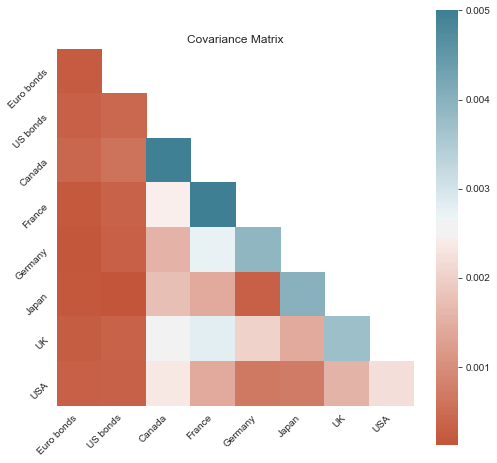

In [35]:
## Create triangle df
np.tril(np.ones(sample_cov_rtns.shape)).astype(np.bool)[:, :]
df_lt = sample_cov_rtns.where(np.tril(np.ones(sample_cov_rtns.shape)).astype(np.bool))
df_lt.columns = cov_mtx.columns

## Plot
sns.set_style(style='white')
plt.figure(figsize = (8, 8))
ax = sns.heatmap(df_lt, cmap = sns.diverging_palette(20, 220, n = 200), square = True)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
ax.set_yticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.title('Covariance Matrix')
plt.show()

### Expected (Realized) Efficient Frontier
The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are sub-optimal because the have a higher level of risk for the defined rate of return. Formally, the frontier is the set of portfolios which satisfy the condition that no other portfolio exists with a higher expected return but with the same standard deviation of return (i.e., the risk).

The efficient frontier theory was introduced by Nobel Laureate Harry Markowitz in 1952 and is a cornerstone of modern portfolio theory (MPT)

### Modern Portfolio Theory
Modern portfolio theory is a theory on how risk-averse investors can construct portfolios to optimize or maximize expected return based on a given level of market risk, emphasizing that risk is an inherent part of higher reward. MPT argues that an investments risk and return characteristics should not be viewed alone, but should be evaluated by how the investment affects the overall portfolio's risk and return.

Based on statistical measures such as variance and correlation, and individual investment's return is less important than how the investment behaves in the context of the entire portfolio. MPT makes the assumption that investors are risk-averse, meaning they prefer a less risky portfolio to a riskier one for a given level of return. Ultimately implying that an investor will take on more risk only if they can expect more reward.

The expected return of the portfolio is calculated as a weighted sum of the individual assets' returns. 

$$ E(R_p) = \sum_{i} w_i E (R_i) $$

Where $R_p$ is the return on the portfolio, $R_i$ is the return on asset $i$ and $w_i$ is the weighting of the component asset $i$ (the proportion of asset $i$ in the portfolio).

The portfolio's risk is a complicated function of the variances of each asset and the correlations of each pair of assets. To calculate the risk of a four asset portfolio, an investor needs each of the four assets' variances and six correlation values, since there are six possible two-asset combinations with four assets. Because of the assert correlations, the total portfolio risk, or standard deviation, is lower than what would be calculated by a weighted sum.

$$ \sigma_p^2 = \sum_{i} w_i^2 \sigma_i^2 + \sum_i \sum_\neq w_i w_j \sigma_i \sigma_j \rho_{ij}$$

Where $\sigma$ is the sample (standard deviation) of the periodic returns on an asset, and $\rho_ij$ is the correlation coefficient between the returns on assets $i$ and $j$. 

Portfolio return volatility (standard deviation) is the square root of the variance.

$$\sigma_p = \sqrt{\sigma_p^2}$$

### Diversification
An investor can reduce portfolio risk simply by holding combinations of instruments not perfectly positively correlated $(-1 \leq \rho_{ij} \leq 1)$. By holding diversified portfolio assets investors can reduce their exposure to individual asset risk. Diversification may allow for the same portfolio expected return with reduced risk. 

If all the asset pairs have correlations of 0—they are perfectly uncorrelated—the portfolio's return variance is the sum over all assets of the square of the fraction held in the asset times the asset's return variance. If all the asset pairs have correlations of 1—they are perfectly positively correlated—then the portfolio return’s standard deviation is the sum of the asset returns’ standard deviations weighted by the fractions held in the portfolio.


In [36]:
# set the number of combinations for imaginary portfolios
num_assets = 8
num_portfolios = 10000
selected = cov_mtx.columns 

np.random.seed(11)
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, mean)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

In [37]:
## a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

## extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

## make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

## get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock +' Weight' for stock in selected]

## reorder dataframe columns
df = df[column_order]
df.head()

,Returns,Volatility,Sharpe Ratio,Euro bonds Weight,US bonds Weight,Canada Weight,France Weight,Germany Weight,Japan Weight,UK Weight,USA Weight
0,0.672286,0.042307,15.890763,0.064528,0.006971,0.165809,0.259491,0.150412,0.173759,0.004575,0.174455
1,0.512531,0.030440,16.837592,0.181824,0.164253,0.140926,0.020992,0.172576,0.165481,0.031871,0.122077
2,0.672469,0.043202,15.565716,0.007182,0.040929,0.110921,0.055366,0.266105,0.286895,0.120829,0.111774
3,0.676529,0.040973,16.511731,0.033909,0.025494,0.216436,0.182065,0.016907,0.145702,0.121979,0.257509
4,0.573161,0.035369,16.205106,0.138516,0.116174,0.106588,0.183138,0.190388,0.065231,0.046286,0.153680


### Sharpe Ratio
The Sharpe ratio was developed by Nobel laureate William F. Sharpe and is used to help investors understand the return of an investment compared to its risk. The ratio measures the performance of an investment compared to a risk-free asset, after adjusting for risk. It is defined as the difference between the returns on the investment and the risk-free return, divided by the standard deviation (volatility) of the investment. It represents the additional amount of return that an investor receives per unit of increase in risk.

The ex-post Sharpe Ratio is calculated as follows:

$$ Sharpe Ratio = \frac{(R_p - R_f)}{\sigma_p} $$

$R_p$ is the return on the portfolio
$R_f$ is the risk-free rate
$\sigma_p$ is the standard deviation of the portfolio's excess return

The Sharpe ratio can be used to evaluate a portfolio's past performance (ex-post) where actual returns are used in the formula. It can also help explain whether a portfolio's excess returns are due to smart investment decisions or a result of too much risk. The greater a portfolio's Sharpe ratio, the better its risk-adjusted-performance. If the analysis results in a negative Sharpe ratio, it either means the risk-free rate is greater than the portfolio’s return, or the portfolio's return is expected to be negative. In either case, a negative Sharpe ratio does not convey any useful meaning.

        - The Sharpe ratio adjusts a portfolio’s past performance—or expected future performance—for the excess 
        risk that was taken by the investor.
        - A high Sharpe ratio is good when compared to similar portfolios or funds with lower returns.
        - The Sharpe ratio has several weaknesses, including an assumption that investment returns are normally distributed.

The portfolios created above can be visualised along with their respective Sharpe ratio in order to see the respective returns and volatility each portfolio holds.


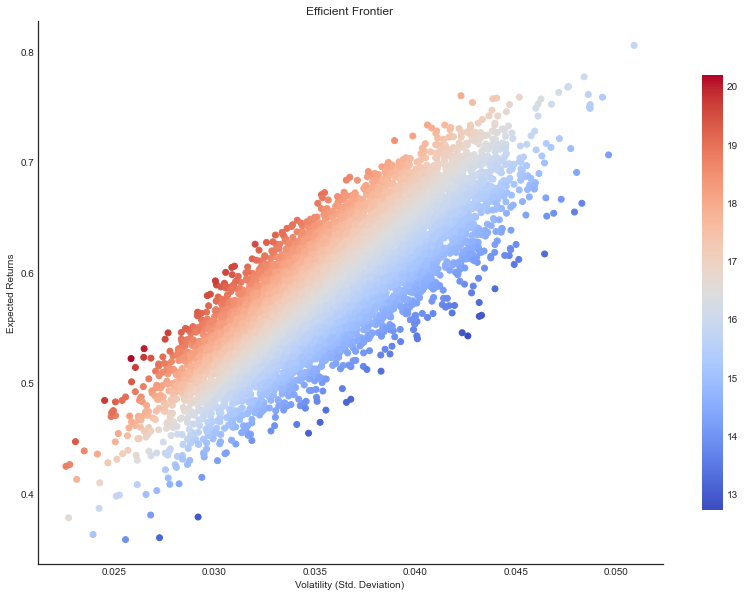

In [38]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.figure(figsize = (14, 10))
plt.style.use('seaborn-white')
plt.scatter(x = df['Volatility'], y = df['Returns'], c=  df['Sharpe Ratio'], cmap = 'coolwarm')
cb = plt.colorbar(shrink = 0.8, drawedges = False)
cb.outline.set_visible(False)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.show()

#### Minimum Variance Portfolio
A minimum variance portfolio (MVP) is a collection of securities that combine to minimize the price volatility of the overall portfolio. To build a minimum variance portfolio, you need to stick with low-volatility investments or a combination of volatile investments with low correlation to each other. In practice, the MVP can only be determined historically (ex post) for a specific sample and return frequency. This means different low volatility portfolios (LVP) co-exist, all aiming to reduce and minimize future volatility (ex ante).

#### Maximum Sharpe Portfolio
The Sharpe ratio measures the performance of an investment compared to a risk-free asset, after adjusting to its risk. Maximum Sharpe Portfolio or Tangency Portfolio is a portfolio on the efficient frontier at the point where line drawn from the point (0, risk-free rate) is tangent to the efficient frontier.

#### Maximum Return Portfolio
A maximum return portfolio is a collection of securities that combine to maximize the price return of the overall portfolio. This portfolio is built with high-risk investments that will (usually) have high volatility. This portfolio is for risk-seeking investors.


In [39]:
## find min volatility, max sharpe and max return values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()
max_return = df['Returns'].max()

## use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]
max_return_port = df.loc[df['Returns'] == max_return]

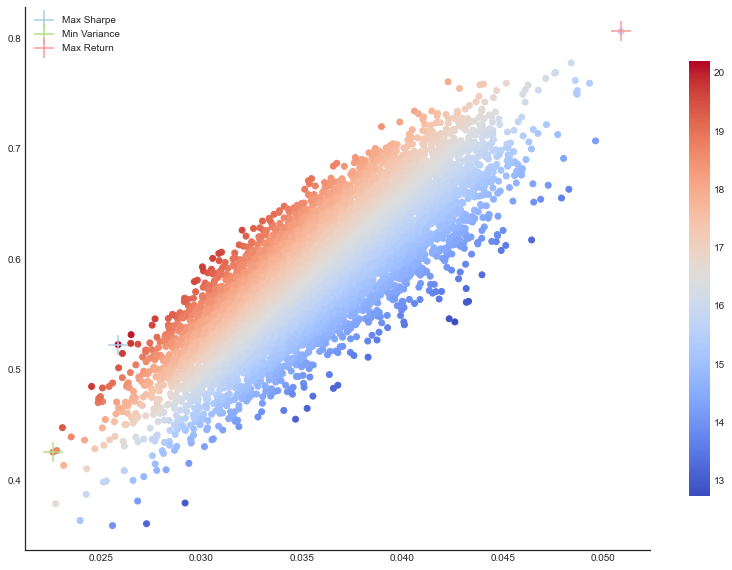

In [40]:
## plot frontier, max sharpe & min Volatility values with a scatterplot
plt.figure(figsize = (14, 10))
plt.style.use('seaborn-white')
plt.scatter(x = df['Volatility'], y = df['Returns'], c=  df['Sharpe Ratio'], cmap = 'coolwarm')
cb = plt.colorbar(shrink = 0.8, drawedges = False)
cb.outline.set_visible(False)
plt.scatter(
    x = sharpe_portfolio['Volatility'], y = sharpe_portfolio['Returns'], c = '#a6cee3', 
    marker = '+', s = 400, label = 'Max Sharpe' )
plt.scatter(
    x = min_variance_port['Volatility'], y = min_variance_port['Returns'], c = '#b2df8a', 
    marker = '+', s = 400, label = 'Min Variance' )
plt.scatter(
    x = max_return_port['Volatility'], y = max_return_port['Returns'], c = '#fb9a99', 
    marker = '+', s = 400, label = 'Max Return' )
plt.legend(loc = 'upper left')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.show()

### Efficient Frontier with no Risk-Free Asset
Every possible combination of risky assets, can be plotted in the risk-expected return space (visualised above: expected return (vertical) versus standard deviation). This is called the 'risk-expected return space'. The left boundary of this region is parabolic and the upper part of the parabolic boundary is the **efficient frontier** in the absence of a risk free asset. Combinations along this upper edge represent portfolios (including no holdings of the risk-free asset) for which there is lowest risk for a given level of expected return. Equivalently, a portfolio lying on the efficient frontier represents the combination offering the best possible expected return for given risk level. The tangent to the upper part of the parabolic boundary is the capital allocation line (CAL).

In order to calculate the efficient frontier an optimisation problem must be constructed. Matrices are preferred calculations for the efficient frontier. In matrix form, for a given "risk tolerance" $q \in [0, \inf)$, the efficient frontier is found by minimizing the following expression:

$$ w^T \sum w - q * R^T w $$

$w$ is a vector of portfolio weights and $\sum_i w_i = 1$ (The weights can be negative, meaning investors can short a security);
$\sum$ is the covariance matrix for the returns of the asset in the portfolio;
$q \geq 0$ is a "risk tolerance" factor, where 0 results in the portfolio with minimal risk and $\inf$ results in the portfolio infinitely far out on the frontier with both expected return and risk unbounded;
$R$ is a vector of expected returns;
$w^T \sum w$ is the variance of the portfolio;
$R^T w$ is the expected return on the portfolio.

The above optimization problem finds the point at which the inverse of the slope of the frontier would be $q$ if portfolio return variance instead of standard deviation were plotted horizontally. The frontier in its entirety is parametric on $q$.

An alternate approach to specifying the efficient frontier is to do so parametrically on the expected portfolio return $R^T w$. This version of the problem requires the minimisation of 

$$ w^T \sum w $$

subject to:

$$ R^T w = \mu $$

The section below uses the cvxopt package to find the optimal portfolio weightings. CVXOPT is a free software package for convex optimization based on the Python programming language. Its main purpose is to make the development of software for convex optimization applications straightforward by building on Python’s extensive standard library and on the strengths of Python as a high-level programming language.


In [41]:
import cvxopt as opt
from cvxopt import blas, solvers

def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    
    ## Calculate risks and returns for frontier
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]

    ## Calculate the 2nd degree polynomial of the frontier curve
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    
    ## Calculate the optimal portfolio
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks, portfolios

In [42]:
weights, estimated_returns, estimated_risks, portfolios = optimal_portfolio(monthly_returns)

     pcost       dcost       gap    pres   dres
 0: -1.0588e+00 -1.8776e+00  1e+01  3e+00  2e+00
 1: -6.7182e-01 -1.6628e+00  1e+00  2e-15  5e-16
 2: -7.4044e-01 -8.8545e-01  1e-01  5e-16  3e-16
 3: -8.5746e-01 -9.0234e-01  4e-02  4e-16  2e-16
 4: -8.7673e-01 -8.7774e-01  1e-03  2e-16  2e-16
 5: -8.7748e-01 -8.7749e-01  1e-05  8e-17  1e-16
 6: -8.7749e-01 -8.7749e-01  1e-07  2e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0587e+00 -1.8776e+00  1e+01  3e+00  2e+00
 1: -6.7181e-01 -1.6628e+00  1e+00  3e-16  4e-16
 2: -7.4043e-01 -8.8544e-01  1e-01  2e-16  3e-16
 3: -8.5745e-01 -9.0232e-01  4e-02  2e-17  1e-16
 4: -8.7671e-01 -8.7771e-01  1e-03  1e-16  1e-16
 5: -8.7746e-01 -8.7747e-01  1e-05  7e-18  1e-16
 6: -8.7746e-01 -8.7746e-01  1e-07  6e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0587e+00 -1.8776e+00  1e+01  3e+00  2e+00
 1: -6.7180e-01 -1.6628e+00  1e+00  6e-16  7e-16
 2: -7.4041e-01 -8.8543e

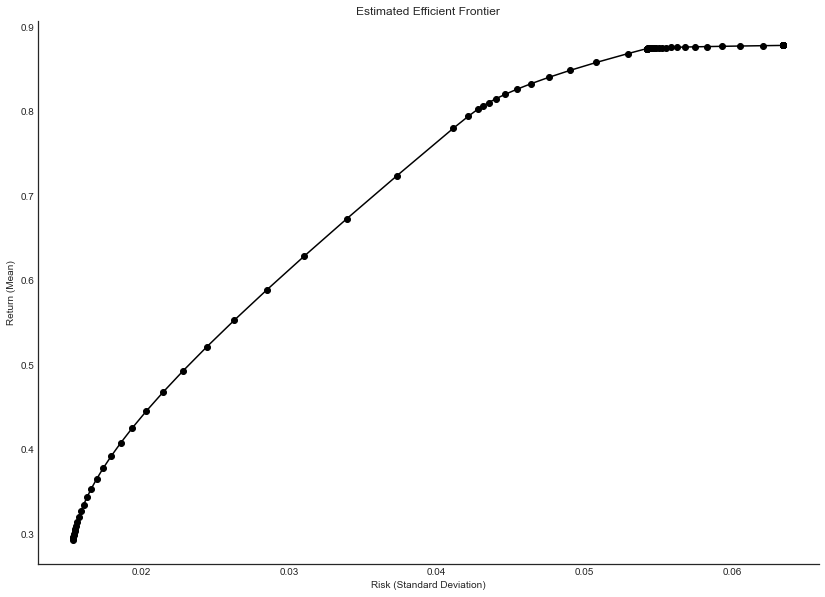

In [43]:
## Plotting Estimated Frontier
fig = plt.figure(figsize = (14, 10))
plt.ylabel('Return (Mean)')
plt.xlabel('Risk (Standard Deviation)')
plt.plot(estimated_risks, estimated_returns, 'y-o', color = 'black')
plt.title('Estimated Efficient Frontier')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.show()

### Actual Frontier
Next, lets compute the actual expected returns and standard deviations for the portfolios that were found in in the realised (estimated) frontier above. Using the W’s from the optimal sample portfolios, the expected return can be estimated and variance of each portfolio using the true returns and true variances found.

In [44]:
## Import weights
weights = pd.read_csv('weights.csv', header = None)

In [45]:
## Calculate actual data
risk_data_actual = [0] * 100
for i in range(100):
    risk_data_actual[i] = np.sqrt(np.asmatrix(weights)[i] @ cov_mtx @ np.asmatrix(weights)[i].transpose())

ret_data_actual = weights @ mean

In [46]:
## Diagonal elements
cov_mtx.to_numpy().diagonal()

array([0.00024336, 0.00040401, 0.003025  , 0.00494209, 0.00386884,
       0.00495616, 0.00361201, 0.001849  ])

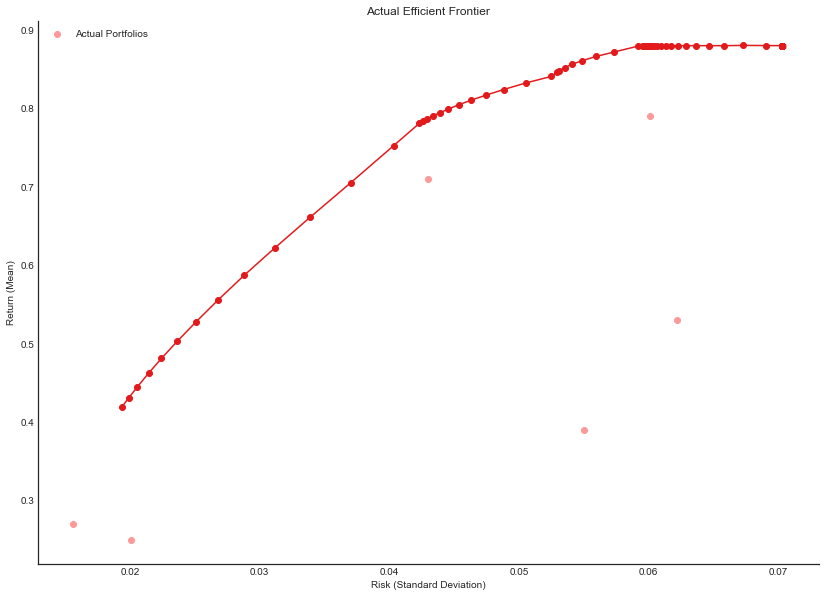

In [47]:
## Plotting actual frontier
fig = plt.figure(figsize = (14, 10))
plt.plot(risk_data_actual, ret_data_actual, 'y-o', color = '#e31a1c')
plt.scatter(np.sqrt(cov_mtx.to_numpy().diagonal()), mean, color = '#fb9a99', label = 'Actual Portfolios')
plt.legend(loc = 'upper left')
plt.title('Actual Efficient Frontier')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.ylabel('Return (Mean)')
plt.xlabel('Risk (Standard Deviation)')
plt.show()

### True Frontier
The true frontier is calculated using the same methodology that was used to find the estimated frontier but using the true returns and true covariance as inputs for the optimal function. Once the true frontier is found, the true, actual and estimated frontiers in will be plotted further below. 

In [48]:
def true_efficient_frontier():
    n = 8
    #returns = np.asmatrix(returns)
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    pbar = opt.matrix(mean)

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                for mu in mus]
    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    # sharpe = returns / risks

    # sharpe_ratio.append(sharpe)

    
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

In [49]:
weights, true_returns, true_risks = true_efficient_frontier()

     pcost       dcost       gap    pres   dres
 0: -1.0712e+00 -1.8799e+00  1e+01  3e+00  2e+00
 1: -6.7847e-01 -1.6661e+00  1e+00  1e-15  4e-16
 2: -7.4840e-01 -8.8773e-01  1e-01  8e-17  4e-16
 3: -8.6762e-01 -8.9279e-01  3e-02  2e-16  2e-16
 4: -8.7969e-01 -8.7995e-01  3e-04  1e-16  3e-16
 5: -8.7982e-01 -8.7983e-01  3e-06  2e-16  2e-16
 6: -8.7982e-01 -8.7982e-01  3e-08  1e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0711e+00 -1.8798e+00  1e+01  3e+00  2e+00
 1: -6.7846e-01 -1.6661e+00  1e+00  1e-15  4e-16
 2: -7.4838e-01 -8.8771e-01  1e-01  5e-16  2e-16
 3: -8.6761e-01 -8.9277e-01  3e-02  1e-16  3e-16
 4: -8.7967e-01 -8.7993e-01  3e-04  3e-16  1e-16
 5: -8.7980e-01 -8.7980e-01  3e-06  6e-17  2e-16
 6: -8.7980e-01 -8.7980e-01  3e-08  2e-17  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0711e+00 -1.8798e+00  1e+01  3e+00  2e+00
 1: -6.7844e-01 -1.6661e+00  1e+00  3e-15  5e-16
 2: -7.4837e-01 -8.8770e

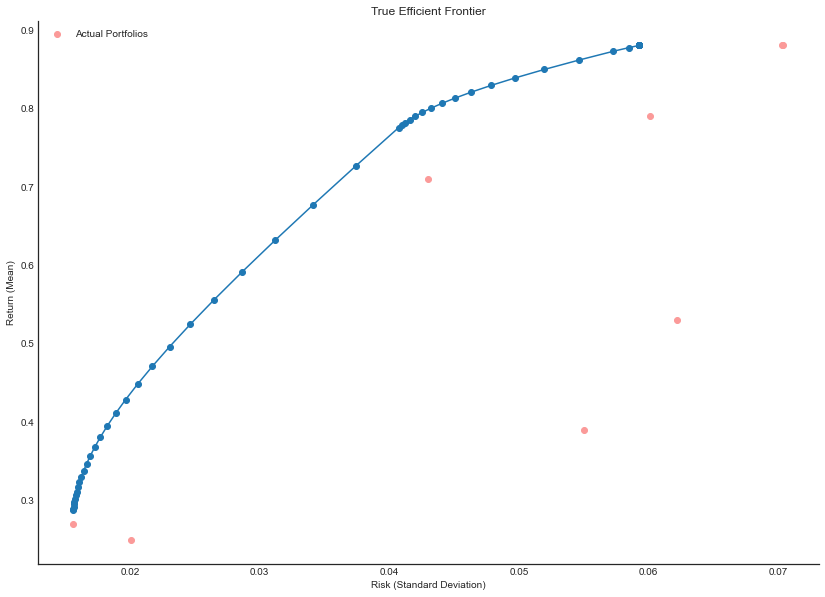

In [50]:
## Plotting 
fig = plt.figure(figsize = (14, 10))
plt.plot(true_risks, true_returns, 'y-o', color = '#1f78b4')
plt.scatter(np.sqrt(cov_mtx.to_numpy().diagonal()), mean, color = '#fb9a99', label = 'Actual Portfolios')
plt.legend(loc = 'upper left')
plt.title('True Efficient Frontier')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.ylabel('Return (Mean)')
plt.xlabel('Risk (Standard Deviation)')
plt.show()

### Actual, Estimated, and True Frontier
The visualisation below shows the true frontier (Blue), the estimated frontier (black) and the actual frontier (red). As we see, the actual frontier is a subset of non-optimal portfolios from the true frontier given that it uses a combination of real assets. The black frontier can follow a different path given that is generated from random samples.

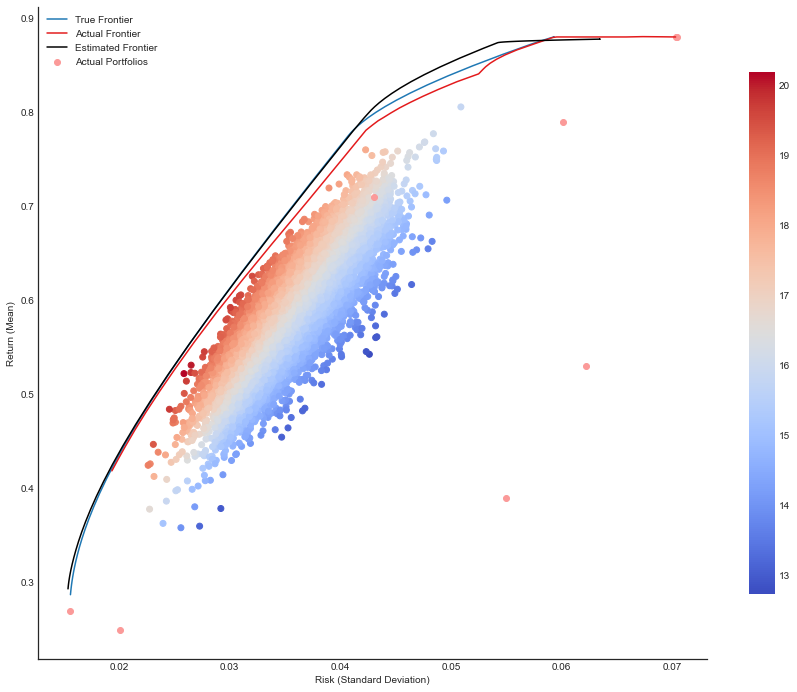

In [51]:
plt.figure(figsize = (15, 12))
#plt.plot(stds, means, 'o')
plt.ylabel('Return (Mean)')
plt.xlabel('Risk (Standard Deviation)')
plt.plot(true_risks, true_returns, color = '#1f78b4' , label = 'True Frontier')
plt.plot(risk_data_actual, ret_data_actual, color = '#e31a1c', label = 'Actual Frontier')
plt.plot(estimated_risks, estimated_returns, color = 'black', label = 'Estimated Frontier')
plt.scatter(x = df['Volatility'], y = df['Returns'], c=  df['Sharpe Ratio'], cmap = 'coolwarm')

#plt.scatter(np.sqrt(cov_mtx.to_numpy().diagonal()), mean, color = 'black')
cb = plt.colorbar(shrink = 0.8, drawedges = False)
cb.outline.set_visible(False)

plt.scatter(np.sqrt(cov_mtx.to_numpy().diagonal()), mean, color = '#fb9a99', label = 'Actual Portfolios')
plt.legend(loc = 'upper left')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.show()

### Problems with Traditional Mean-Variance Analysis
The traditional mean-variance analysis of Markowitz has some important weaknesses when applied naively in practice. They include the tendency to produce extreme portfolios combining extreme short positions with extreme long positions. As a result, portfolio managers (correctly) do not trust these extreme portfolios. This problem is invariably caused by estimation errors in the mean return vector and covariance matrix.

Note that the blue curve above is the true frontier computed using the true mean vector and covariance matrix. The first observation is that the estimated frontiers are quite random and can differ greatly from the true frontier. They may lie below or above the true frontier or they may cross it and an investor who uses such an estimated frontier to make investment decisions may end up choosing a poor portfolio. The dashed red curves above are the realized frontiers that depict the true portfolio mean - volatility trade-off that results from making decisions based on the estimated frontiers. In contrast to the estimated frontiers, the realized frontiers must always lie below the true frontier. If the realised (estimated) frontiers were drawn multiple times some of the realized frontiers would lie very close to the true frontier and so in these cases an investor might do very well. But in other cases the realized frontier is far from the (generally unobtainable) true efficient frontier.


## Conclusion
In practice it is quite common for portfolio managers to manage and assess performance relative to a benchmark portfolio. This benchmark portfolio typically represents a particular asset class. A passive manager in this asset class might aim to replicate this benchmark where as an active manager would aim to outperform the benchmark. The mean-variance framework described in this project can be easily adapted to this latter case. In particular, the expected return is now replaced by the expected excess return where the excess return is $R^T>(w−w^B)$, the portfolio return minus the benchmark return where $w^B$ is used to denote the benchmark. Similarly the return variance is replaced by the variance of the tracking error, i.e. $Var(R^T>(w−w^B))$. This is still a convex quadratic optimization problem which is easy to solve. 

The nexts steps here are to investigte the Capital Asset Pricing Model (CAPM) which states that the tangency portfolio is held by all investors and because markets must clear, it can be identified that this portfolio is the market portfolio. The efficient frontier is then termed the capital market line. The CAPM result is one of the most famous results in all of finance and, even though it arises from a simple one-period model, it provides considerable insight to the problem of asset-pricing. 

The Black-Litterman model might also be studied next as it was developed in part to ameliorate the problem of mean-variance analysis producing extreme portfolios as outlined in this paper. However, it also allows investors to impose their own
subjective views on the market-place and it has been very influential in the asset-allocation world.

## Further Reading
#### Scenario Analysis
https://corporatefinanceinstitute.com/resources/knowledge/modeling/scenario-analysis/  
https://www.investopedia.com/terms/s/scenario_analysis.asp  
  
#### Pivot Tables
https://en.wikipedia.org/wiki/Pivot_table  
https://www.dataquest.io/blog/pandas-pivot-table/  

#### The Greeks
https://en.wikipedia.org/wiki/Greeks_(finance)  
https://www.investopedia.com/terms/g/greeks.asp  
https://www.optionsplaybook.com/options-introduction/option-greeks/  

#### Modern Portfolio Theory
https://www.investopedia.com/terms/m/modernportfoliotheory.asp  
https://www.guidedchoice.com/video/dr-harry-markowitz-father-of-modern-portfolio-theory/  
https://en.wikipedia.org/wiki/Modern_portfolio_theory  

#### Efficient Frontier 
https://en.wikipedia.org/wiki/Efficient_frontier  
https://towardsdatascience.com/understanding-efficient-frontier-46f1a429d526  